In [102]:
import pandas as np
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader.data import DataReader
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr
from datetime import datetime
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense, Dropout
from keras.optimizers import Adam
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


# S&P500 stocks IDs


In [103]:

url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
sp500_table = pd.read_html(url)[0]
tickers = sp500_table['Symbol'].tolist()

print(tickers)

['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'APO', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BAX', 'BDX', 'BRK.B', 'BBY', 'TECH', 'BIIB', 'BLK', 'BX', 'BK', 'BA', 'BKNG', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BLDR', 'BG', 'BXP', 'CHRW', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CAT', 'CBOE', 'CBRE', 'CDW', 'COR', 'CNC', 'CNP', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CPAY', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CRWD', 'CCI', 'CSX', 'CMI', 'CVS', 'DHR', 'DRI', 'DVA', 'DAY', 'D

# Data for the S&P500 stocks

In [104]:

# 1. Get the list of S&P 500 tickers
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
sp500_table = pd.read_html(url)[0]
tickers = sp500_table['Symbol'].tolist()
tickers.remove('BRK.B') #try renaming
tickers.remove('BF.B')
# 2. Download historical stock price and volume data
data = yf.download(tickers, start="2010-01-01", end=pd.Timestamp.today(), group_by='ticker', threads=True)


[*********************100%***********************]  501 of 501 completed


In [105]:
data.head()

Ticker           EQIX                                                 ROL  \
Price            Open       High        Low      Close   Volume      Open   
Date                                                                        
2010-01-04  80.555491  82.899863  80.547933  82.854485   576300  3.075067   
2010-01-05  82.877133  82.877133  81.962074  82.083076   681900  3.113109   
2010-01-06  82.393185  83.618308  81.841127  82.831810  1397500  3.086163   
2010-01-07  82.620039  83.451910  80.646232  81.137794   797200  3.082992   
2010-01-08  80.767222  81.130218  80.086598  80.744530   432400  3.106769   

Ticker                                            ...        MKC             \
Price           High       Low     Close  Volume  ...       Open       High   
Date                                              ...                         
2010-01-04  3.136886  3.056046  3.108354  839363  ...  13.499167  13.499167   
2010-01-05  3.117865  3.078237  3.092503  701663  ...  13.428719  13.465794   
2010-01-06  3.130546  3.086163  3.094088  841388  ...  13.413894  13.488045   
2010-01-07  3.121034  3.049705  3.117864  536119  ...  13.506580  13.588146   
2010-01-08  3.121035  3.089333  3.113109  330581  ...  13.573318  13.614101   

Ticker                                           CMI                        \
Price             Low      Close   Volume       Open       High        Low   
Date                                                                         
2010-01-04  13.369403  13.458384   980000  32.220044  32.748357  32.157480   
2010-01-05  13.369398  13.421304  1097400  32.845670  33.492157  32.644077   
2010-01-06  13.350865  13.473214  1175800  33.262742  33.798005  33.214082   
2010-01-07  13.413891  13.577023  1399800  33.547764  35.487223  33.540814   
2010-01-08  13.428724  13.614101  1332600  35.000634  37.829881  34.826848   

Ticker                          
Price           Close   Volume  
Date                            
2010-01-04  32.630180  1148600  
2010-01-05  33.401787  1592300  
2010-01-06  33.707638  1745900  
2010-01-07  35.417709  3558600  
2010-01-08  37.308521  4848000  

[5 rows x 2505 columns]

# Calculating Vals to pick the best stocks

Select the top 5 stable stocks (low volatility) with strong upward movement (high momentum) and balanced RSI (30–70).

In [106]:
stock = []
rsi = []
vol = []
mom = []
sma = []

for i in tickers:
    data_sample = data[i].dropna().tail(30)

    if len(data_sample) < 10:
        continue

    sma_val = data_sample['Close'].tail(5).mean()

    delta = data_sample['Close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    rsi_val = 100 - (100 / (1 + gain.mean() / loss.mean()))

    mom_val = data_sample['Close'].iloc[-1] - data_sample['Close'].iloc[-5]
    vol_val = data_sample['Close'].pct_change().tail(10).std()

    stock.append(i)
    rsi.append(rsi_val)
    vol.append(vol_val)
    mom.append(mom_val)
    sma.append(sma_val)

df = pd.DataFrame({
    "stock": stock,
    "rsi": rsi,
    "vol": vol,
    "mom": mom,
    "sma": sma
})

best_stocks = df[
    (df['rsi'].between(30, 70))
].sort_values(
by=['vol', 'mom'],
ascending=[True, False]
).head(5)

print(best_stocks)
best_stocks = best_stocks['stock'].tolist()
print(best_stocks)


    stock        rsi       vol       mom         sma
266     K  45.092032  0.003702  0.650002   82.004001
469  VRTX  50.292173  0.013382  9.660004  477.787994
478   WBA  57.784426  0.014010  0.070000   10.710000
484   WEC  48.043598  0.015937  3.750000  104.598000
92    CNP  60.080250  0.016119  1.080002   36.016000
['K', 'VRTX', 'WBA', 'WEC', 'CNP']


# Example with one of the stocks, WEC



For sentiment analysis, we should try more popular stocks like Apple, Amazon, Tesla, Microsoft, Meta...

In [107]:
# Test
appl_data = data['WEC']


appl_data["Change"] = appl_data['Close'].pct_change(5)

appl_data['SMA'] = appl_data['Close'].rolling(5).mean()  # change to 1 for 1-day prediction

delta = appl_data['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
appl_data['RSI'] = 100 - (100 / (1 + gain.rolling(14).mean() / loss.rolling(14).mean()))


appl_data['Volatility'] = appl_data['Close'].pct_change().rolling(5).std()  # change to 1 for 1-day prediction


appl_data['Momentum'] = appl_data['Close'].diff(5)  # change to 1 for 1-day prediction


appl_data = appl_data.dropna()


print(appl_data[['Close', 'SMA', 'RSI', 'Volatility', 'Momentum','Change']].tail(6))





Price            Close         SMA        RSI  Volatility  Momentum    Change
Date                                                                         
2025-04-04  104.360001  107.920000  40.142844    0.019306 -3.190002 -0.029661
2025-04-07  103.209999  106.765999  34.094057    0.016068 -5.770004 -0.052946
2025-04-08  102.949997  105.577998  34.094039    0.015823 -5.940002 -0.054550
2025-04-09  104.360001  104.681999  38.949412    0.019116 -4.479996 -0.041161
2025-04-10  105.510002  104.078000  45.875654    0.021004 -3.019997 -0.027826
2025-04-11  106.959999  104.598000  53.646475    0.011197  2.599998  0.024914


<ipython-input-107-2e8796300d1c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  appl_data["Change"] = appl_data['Close'].pct_change(5)
<ipython-input-107-2e8796300d1c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  appl_data['SMA'] = appl_data['Close'].rolling(5).mean()  # change to 1 for 1-day prediction
<ipython-input-107-2e8796300d1c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

# Scaling & Splitting data

In [108]:



appl_data['Date'] = pd.to_datetime(appl_data.index if 'Date' not in appl_data.columns else appl_data['Date'])
start_date = appl_data['Date'].min()
end_date = appl_data['Date'].max()
train_end_date = start_date + pd.DateOffset(years=13)
test_start_date = train_end_date + pd.DateOffset(days=1)

train_data = appl_data[appl_data['Date'] <= train_end_date].copy()
test_data = appl_data[appl_data['Date'] >= test_start_date].copy()


features = ['Close', 'Change', 'SMA', 'RSI', 'Volatility', 'Momentum']
scaler = MinMaxScaler(feature_range=(-1, 1))


train_features = train_data[features].dropna()
test_features = test_data[features].dropna()
scaled_train = scaler.fit_transform(train_features)
scaled_test = scaler.transform(test_features)


def create_sequences(features, targets, seq_length=5):
    X, y = [], []
    for i in range(len(features) - seq_length):
        X.append(features[i:i+seq_length])
        y.append(targets[i + seq_length])
    return np.array(X), np.array(y)


y_train_values = train_data['Change'].loc[train_features.index].values
y_test_values = test_data['Change'].loc[test_features.index].values

X_train, y_train = create_sequences(scaled_train, y_train_values)
X_test, y_test = create_sequences(scaled_test, y_test_values)

print(f"Training shapes: X={X_train.shape}, y={y_train.shape}")
print(f"Testing shapes: X={X_test.shape}, y={y_test.shape}")
print(X_train)

Training shapes: X=(3269, 5, 6), y=(3269,)
Testing shapes: X=(550, 5, 6), y=(550,)
[[[-0.99116276 -0.14453793 -0.98752253 -0.13689266 -0.81137639
    0.07866314]
  [-0.9934807  -0.19763352 -0.99001521 -0.0747666  -0.84488524
    0.06710326]
  [-0.99384291 -0.18873159 -0.99231839 -0.19840303 -0.84076731
    0.06910691]
  [-0.99420498 -0.16711658 -0.99416964 -0.18864347 -0.83710451
    0.07388532]
  [-0.99391527 -0.08115917 -0.99428624 -0.25500955 -0.94109992
    0.09222677]]

 [[-0.9934807  -0.19763352 -0.99001521 -0.0747666  -0.84488524
    0.06710326]
  [-0.99384291 -0.18873159 -0.99231839 -0.19840303 -0.84076731
    0.06910691]
  [-0.99420498 -0.16711658 -0.99416964 -0.18864347 -0.83710451
    0.07388532]
  [-0.99391527 -0.08115917 -0.99428624 -0.25500955 -0.94109992
    0.09222677]
  [-0.99253899 -0.0892189  -0.9945632  -0.43037183 -0.95321388
    0.09053126]]

 [[-0.99384291 -0.18873159 -0.99231839 -0.19840303 -0.84076731
    0.06910691]
  [-0.99420498 -0.16711658 -0.99416964 -0.18

# LSTM Model

In [109]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense, Dropout
from keras.optimizers import Adam

# Define the model
def build_lstm_model(input_shape):
    model = Sequential()

    # LSTM Layer 1
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    # LSTM Layer 2
    model.add(LSTM(units=50, return_sequences=False))

    # Dense Layer (Output layer)
    model.add(Dense(units=1))  # Predicting the next day's change (continuous value)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error', metrics=['mae'])

    return model


input_shape = (X_train.shape[1], X_train.shape[2])  # (sequence_length, num_features)

# Build and summarize the model
model = build_lstm_model(input_shape)
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test data
predictions = model.predict(X_test)

# Evaluate with Mean Absolute Error (MAE) and Mean Squared Error (MSE)
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 5, 50)          │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,651 (123.64 KB)

 Trainable params: 31,651 (123.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0046 - mae: 0.0381 - val_loss: 3.0388e-04 - val_mae: 0.0138
Epoch 2/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.7689e-04 - mae: 0.0118 - val_loss: 2.7244e-04 - val_mae: 0.0129
Epoch 3/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.9448e-04 - mae: 0.0122 - val_loss: 4.0675e-04 - val_mae: 0.0163
Epoch 4/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.7055e-04 - mae: 0.0127 - val_loss: 3.8675e-04 - val_mae: 0.0158
Epoch 5/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.2256e-04 - mae: 0.0130 - val_loss: 2.6851e-04 - val_mae: 0.0128
Epoch 6/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.8889e-04 - mae: 0.0119 - val_loss: 2.8567e-04 - val_mae: 0.0133
Epoch 7/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.7334e-04 - mae: 0.0116 - val_loss: 2.5251e-04 - val_mae: 0.0125
Epoch 8/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.5124e-04 - mae: 0.0115 - val_loss: 3.3575e-04 - val_mae: 

# Plotting true values and the predicted ones

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Date
2025-04-08   -0.054550
2025-04-09   -0.041161
2025-04-10   -0.027826
2025-04-11    0.024914
Name: Change, dtype: float64


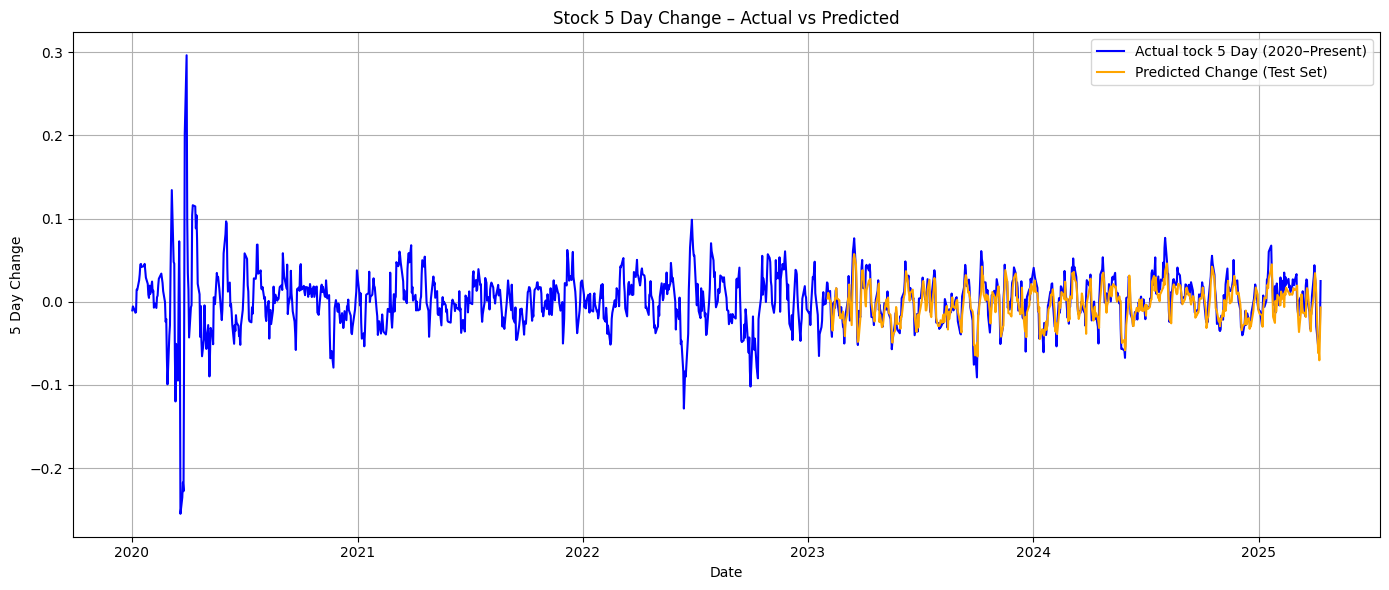

In [110]:
import matplotlib.pyplot as plt
import pandas as pd

y_pred = model.predict(X_test)
# Full actual change series starting from 2020
actual_full = appl_data['Change']
actual_full = actual_full[actual_full.index >= "2020-01-01"]

print(actual_full.tail(4))

test_len = len(y_test)
test_change = appl_data['Change'].iloc[-test_len:]
test_dates = test_change.index

predicted = pd.Series(y_pred.flatten(), index=test_dates)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(actual_full, label='Actual tock 5 Day (2020–Present)', color='blue')
plt.plot(predicted, label='Predicted Change (Test Set)', color='orange')

plt.title("Stock 5 Day Change – Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("5 Day Change")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# R^2 metric

In [111]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.3f}")

R² Score: 0.644


# Classifying Stock Moves into Drop/Flat/Rise & Measuring Accuracy

In [112]:

bins = [-np.inf, -0.01, 0.01, np.inf]
labels = [0, 1, 2]  # 0 = drop, 1 = flat, 2 = rise
y_test_bins = pd.cut(y_test, bins=bins, labels=labels)
y_pred_bins = pd.cut(y_pred.flatten(), bins=bins, labels=labels)

actual_counts = y_test_bins.value_counts().sort_index()
predicted_counts = y_pred_bins.value_counts().sort_index()

from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test_bins, y_pred_bins)

print(f"Binned Accuracy: {acc:.2%}")

Binned Accuracy: 64.73%


# Testing code for 5 day prediction from today

idk if this is right

In [113]:
# 1. Define THE SAME features used in training (copy-pasted from your code)
features = ['Close', 'Change', 'SMA', 'RSI', 'Volatility', 'Momentum']

# 2. Get last 5 days (WITH ALL 6 FEATURES)
last_5_days = appl_data[features].dropna().tail(5)

scaled_data = scaler.transform(last_5_days)  # Uses same 6-feature scaler

# 4. Reshape for LSTM (1, 5, 6)
X_pred = scaled_data.reshape(1, 5, 6)  # 1 batch, 5 timesteps, 6 features

# 5. Predict
predicted_change = model.predict(X_pred, verbose=0)[0][0]
print(f"Predicted 5-day change: {predicted_change:.2%}")

Predicted 5-day change: 3.25%
